In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from preamble import *
from IPython.core.display import HTML

plt.rcParams['figure.dpi'] = 100  # Use 300 for PDF, 100 for slides

HTML('''<style>
html, body {overflow-y: visible !important} 
.CodeMirror {min-width: 105% !important;} 
.rise-enabled .CodeMirror, .rise-enabled .output_subarea {
    font-size: 140%; line-height: 1.2; overflow: visible;
} 
.output_subarea pre {width: 110%}
</style>''')  # For slides

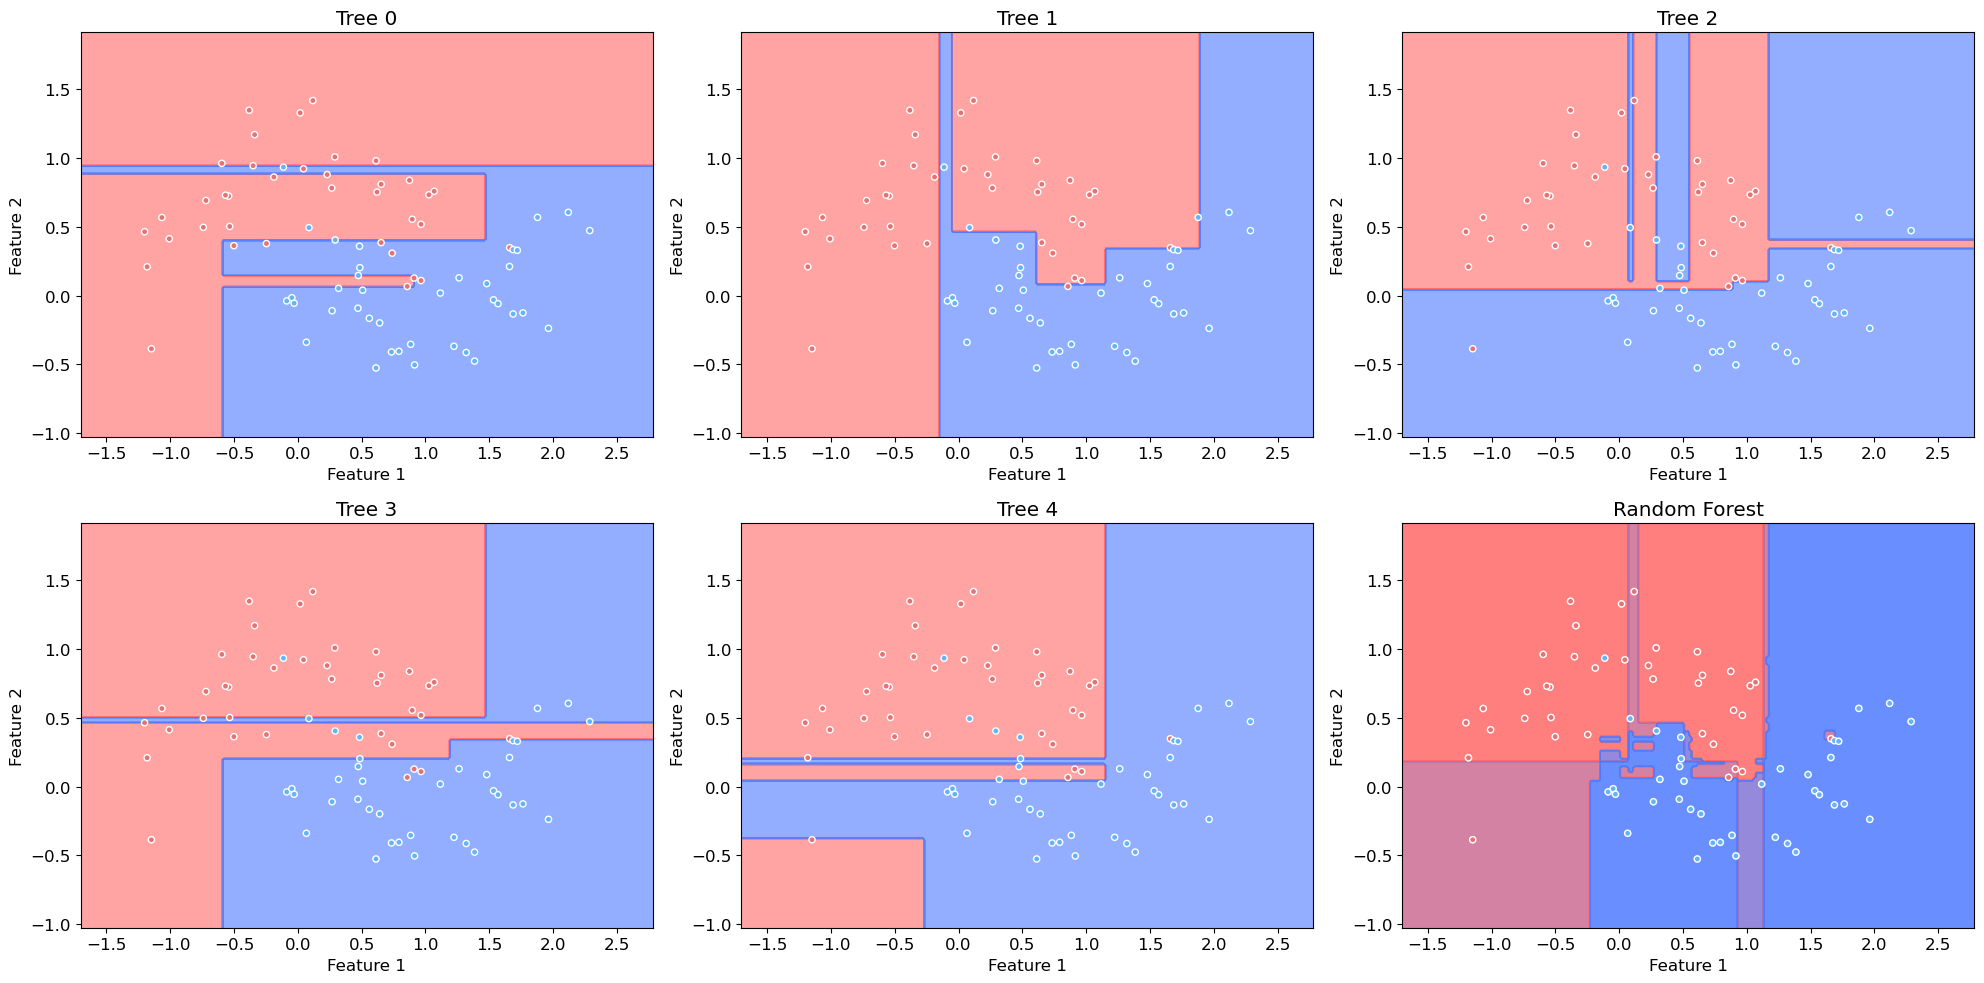

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Generate sample data
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create and train the random forest
forest = RandomForestClassifier(n_estimators=10, random_state=2)
forest.fit(X_train, y_train)

# Create custom colormap with pastel colors
custom_colors = ['#ff6666', '#4d79ff']  # Pastel red and blue
custom_cmap = ListedColormap(custom_colors)

# Function to plot decision boundaries
def plot_decision_boundary(clf, X, y, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
        
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Make predictions for each point in the mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary with custom colors
    ax.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.6)
    
    # Plot scatter points with custom colors
    scatter_colors = ['#e57373', '#64b5f6']
    scatter_cmap = ListedColormap(scatter_colors)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=scatter_cmap, 
              edgecolors='white', s=20)
    
    if title:
        ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Set up the plot
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot individual trees
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    plot_decision_boundary(tree, X_train, y_train, ax=ax, title=f"Tree {i}")

# Plot the random forest
plot_decision_boundary(forest, X_train, y_train, ax=axes[-1, -1], title="Random Forest")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import ShuffleSplit, train_test_split

# Bias-Variance Computation 
def compute_bias_variance(clf, X, y):
    # Bootstraps
    n_repeat = 40 # 40 is on the low side to get a good estimate. 100 is better.
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

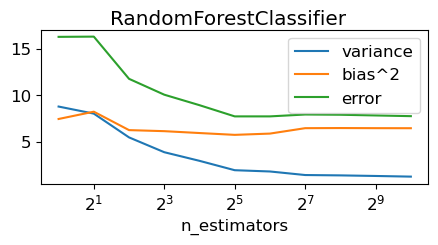

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

cancer = load_breast_cancer()

def plot_bias_variance_rf(clf, X, y):
    bias_scores = []
    var_scores = []
    err_scores = []
    n_estimators= [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    for i in n_estimators:
        b, v, e = compute_bias_variance(clf.set_params(random_state=0, n_estimators=i), X, y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(5,2))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(clf.__class__.__name__)
    plt.plot(n_estimators, var_scores, label="variance")
    plt.plot(n_estimators, np.square(bias_scores), label="bias^2")
    plt.plot(n_estimators, err_scores, label="error")
    plt.xscale('log', base=2)  # Changed from 'basex' to 'base'
    plt.xlabel("n_estimators")
    plt.legend(loc="best")
    plt.show()

X, y = cancer.data, cancer.target
rf = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
plot_bias_variance_rf(rf, X, y)

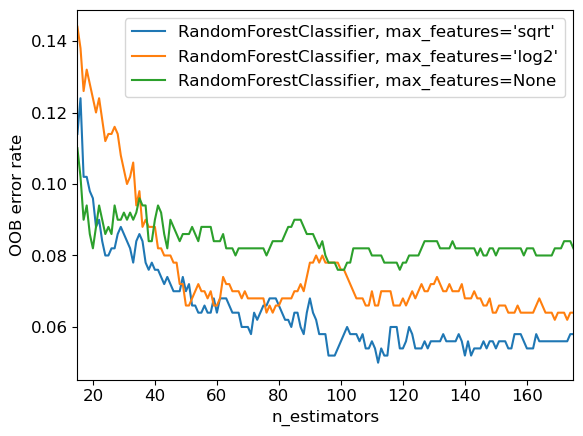

In [6]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [7]:
from sklearn.datasets import load_breast_cancer
import numpy as np

cancer = load_breast_cancer()

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

    
X, y = cancer.data, cancer.target
forest = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
forest.fit(X,y)
plt.rcParams.update({'font.size':8})
plot_feature_importances_cancer(forest)

In [8]:
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.preprocessing import normalize

# Code from https://xavierbourretsicotte.github.io/AdaBoost.html
def AdaBoost_scratch(X,y, M=10, learning_rate = 0.5):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [],[],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))
        sample_weight *= np.exp(-estimator_weight * np.invert(incorrect * ((sample_weight > 0) | (estimator_weight < 0))))
        sample_weight /= np.linalg.norm(sample_weight)
        
        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        
    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    #print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list, estimator_error_list

def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1

    # Get current axis and plot
    if ax is None:
        ax = plt.gca()
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    
    # Plot classifier background
    if classifier is not None:
        xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
        
        #Check what methods are available
        if hasattr(classifier, "decision_function"):
            zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
        elif hasattr(classifier, "predict_proba"):
            zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
        else:
            zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )

        # reshape result and plot
        Z = zz.reshape(xx.shape)
    
        ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5, levels=[0,0.5,1])
        #ax.contour(xx, yy, Z, 2, cmap='RdBu', levels=[0,0.5,1])


from sklearn.datasets import make_circles
Xa, ya = make_circles(n_samples=400, noise=0.15, factor=0.5, random_state=1)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

estimator_list, estimator_weight_list, sample_weight_list, estimator_error_list = AdaBoost_scratch(Xa, ya, M=60, learning_rate = 0.9)

@interact
def plot_adaboost(iteration=(0,60,1)):
    if iteration == 0:
        s_weights = (sample_weight_list[0,:] / sample_weight_list[0,:].sum() ) * 40
        plot_decision_boundary(None, Xa, ya, N = 20, scatter_weights =s_weights)
    else:
        s_weights = (sample_weight_list[iteration,:] / sample_weight_list[iteration,:].sum() ) * 40
        plot_decision_boundary(estimator_list[iteration-1], Xa, ya, N = 20, scatter_weights =s_weights ) 
        print("Base model {}, error: {:.2f}, weight: {:.2f}".format(
            iteration,estimator_error_list[iteration-1],estimator_weight_list[iteration-1]))
        

interactive(children=(IntSlider(value=30, description='iteration', max=60), Output()), _dom_classes=('widget-i…

Base model 1, error: 0.35, weight: 0.56


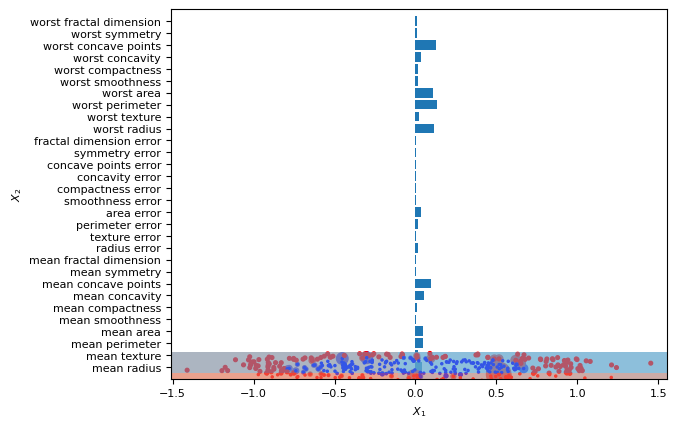

Base model 5, error: 0.21, weight: 1.19


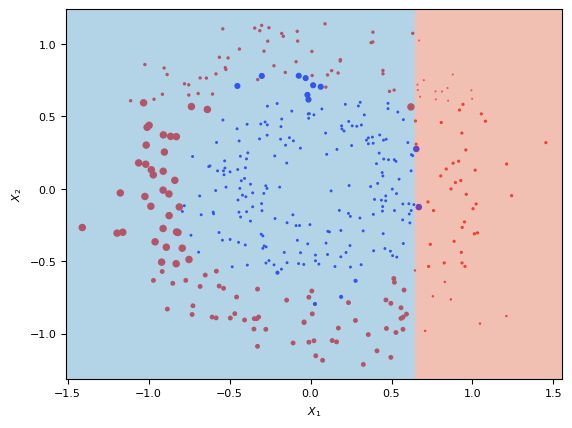

Base model 38, error: 0.35, weight: 0.56


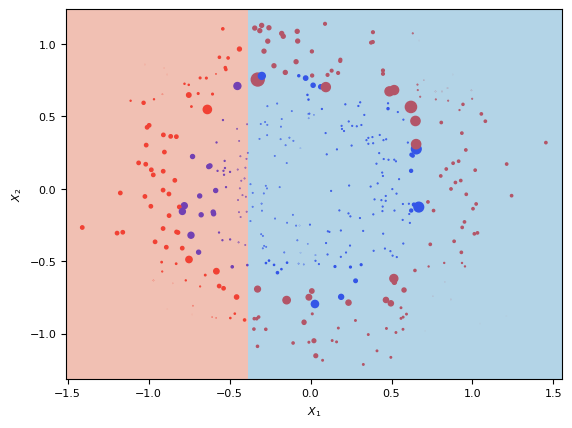

Base model 55, error: 0.31, weight: 0.70


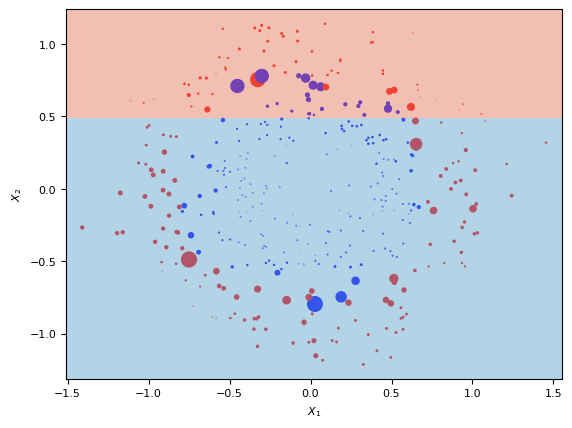

In [9]:
for iteration in [1, 5, 38, 55]:
    plot_adaboost(iteration)
    plt.show()

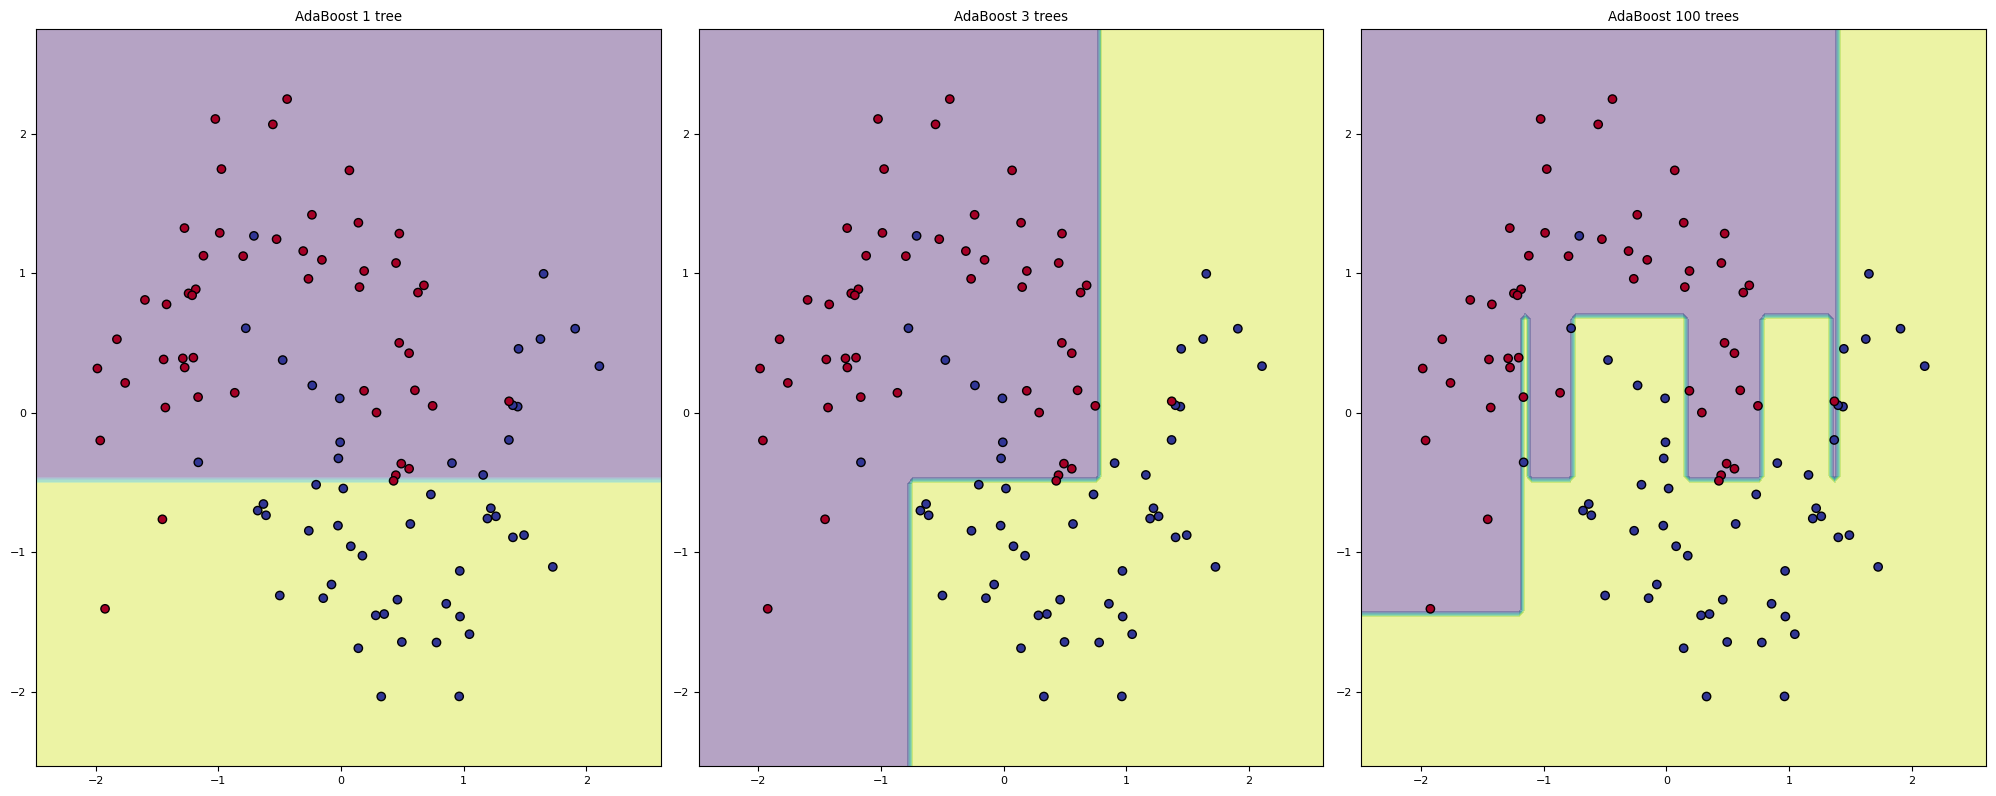

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

def plot_classifiers(names, classifiers, figsize=(20, 8)):
    # Generate sample data
    X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
    X = StandardScaler().fit_transform(X)
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))

    # Plot classifiers
    fig, axes = plt.subplots(1, len(classifiers), figsize=figsize)
    
    for ax, clf, name in zip(axes, classifiers, names):
        # Fit and plot classifier
        clf.fit(X, y)
        
        # Plot decision boundary
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.4)
        
        # Plot training points
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
        
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_title(name)
    
    plt.tight_layout()
    return fig

# Create and plot classifiers
names = ["AdaBoost 1 tree", "AdaBoost 3 trees", "AdaBoost 100 trees"]

classifiers = [
    AdaBoostClassifier(n_estimators=1, random_state=0, learning_rate=0.5),
    AdaBoostClassifier(n_estimators=3, random_state=0, learning_rate=0.5),
    AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.5)
]

fig = plot_classifiers(names, classifiers, figsize=(20, 8))
plt.show()


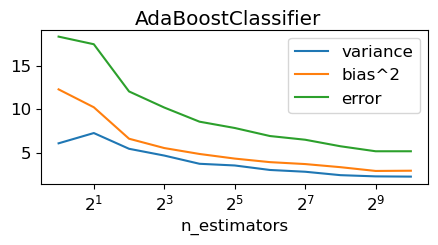

In [11]:
X, y = cancer.data, cancer.target
ab = AdaBoostClassifier(random_state=0, n_estimators=1024)
plot_bias_variance_rf(ab, X, y)

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


In [13]:
# We are overfitting. We can decrease max_depth
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [14]:
# or decrease the learning rate (less effect) 
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train) 

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.958


In [15]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plt.rcParams.update({'font.size':8})
plot_feature_importances_cancer(gbrt)